# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os


2024-03-12 10:22:05.807446: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 10:22:05.833052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 10:22:05.833074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 10:22:05.833456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 10:22:05.837815: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


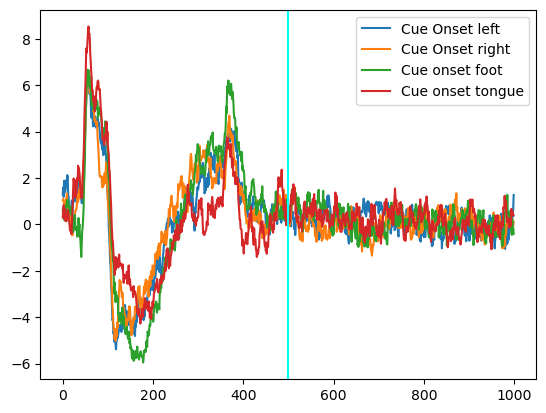

In [3]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






# Data Preprocessing

In [4]:

def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# CNN Model Architecture

In [5]:
from EEG_CNN import CNN
from EEG_ResNet import ResNetCustom, Good_Resnet

In [6]:
import itertools
from keras.utils import plot_model
# Building the CNN model using sequential class
reg = {'reg 1e-2': 1e-2}
filters = {'5x1 filter': 5}
convdepth = {'6 convlayers': 6}
pool = {'pool 3': 3}
dropout = {'dropout 0.4': 0.4, 'dropout 0.5': 0.5, 'dropout 0.6': 0.6}
resdepth = {'1 resdepth': 1}
hyperparams = [reg, filters, convdepth, pool, dropout, resdepth]

# resnet = ResNetCustom()
# resnet.summary()
models_names = []
# models = [ResNetCustom(reg=0.01, pool_size=3, dropout=0.5, first_conv_num=25, first_conv_size=5,
#                        res_filter_sizes=[5 for _ in range(10)],
#                        res_num_filters=[min(200, 25 * (2 ** i)) for i in range(10)])]
models = []

for a in itertools.product(*[hyperparam.items() for hyperparam in hyperparams]):
    models_names.append([i[0] for i in a])
    models.append(Good_Resnet(reg = a[0][1], filters=[a[1][1] for _ in range(a[2][1])],
                               num_filters=[min(200, 25 * (2 ** i)) for i in range(a[2][1])],
                               pool_size=a[3][1],
                               dropout=a[4][1],
                               res_block_depth=a[5][1],
                               input_shape=(400, 1, 22)))
    models[-1].summary()
# plot_model(models[0], to_file='../Gallery/ResNetCustom.png', show_shapes=True, show_layer_names=True)
# for a in itertools.product(mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()):
#     models_names.append([i[0] for i in a])
#     models.append(CNN(input_shape=(400,1,22), use_max_pool=a[0][1], reg=a[1][1], dropout_on_conv=a[2][1], 
#                       filters=[a[3][1] for _ in range(a[4][1])],
#                       num_filters=[min(200, 25 * (2 ** i)) for i in range(a[4][1])]))

# Printing the model summary
# basic_cnn_model.summary()


2024-03-12 10:22:09.100742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 10:22:09.118264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 10:22:09.118397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 1, 22)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 1, 25)           2775      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 134, 1, 25)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 134, 1, 25)           100       ['max_pooling2d[0][0]']   

# Train CNN Model

In [7]:
# Model parameter
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)
learning_rate = 3e-4

epochs = 250
# epochs=1
# cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
# Compiling the model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
for model in models:
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
histories = []
for i, (model, model_name) in enumerate(zip(models, models_names)):
# Training and validating the model
    print(f"Training model {i+1} / {len(models)}:")
    print(model_name)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=8, min_lr=3e-5)
    histories.append(model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=True)
    )
    print(histories[-1].history['val_accuracy'][-1])



Training model 1 / 3:
['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '1 resdepth']


Epoch 1/250


2024-03-12 10:22:13.253180: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-12 10:22:13.624092: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-12 10:22:14.885397: I external/local_xla/xla/service/service.cc:168] XLA service 0x71572970ee20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 10:22:14.885426: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-12 10:22:14.889473: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710264134.945205  185550 device_compiler.h:186] Compiled cluster us

117/117 [==============================] - 12s 40ms/step - loss: 21.1444 - accuracy: 0.2575 - val_loss: 19.3580 - val_accuracy: 0.2240 - lr: 3.0000e-04
Epoch 2/250
117/117 [==============================] - 2s 18ms/step - loss: 19.1084 - accuracy: 0.2633 - val_loss: 17.9658 - val_accuracy: 0.2280 - lr: 3.0000e-04
Epoch 3/250
117/117 [==============================] - 2s 20ms/step - loss: 17.6513 - accuracy: 0.2611 - val_loss: 16.6392 - val_accuracy: 0.2240 - lr: 3.0000e-04
Epoch 4/250
117/117 [==============================] - 2s 20ms/step - loss: 16.2254 - accuracy: 0.2669 - val_loss: 15.2682 - val_accuracy: 0.2400 - lr: 3.0000e-04
Epoch 5/250
117/117 [==============================] - 2s 20ms/step - loss: 14.8335 - accuracy: 0.2634 - val_loss: 13.9274 - val_accuracy: 0.2400 - lr: 3.0000e-04
Epoch 6/250
117/117 [==============================] - 2s 20ms/step - loss: 13.4778 - accuracy: 0.2544 - val_loss: 12.6311 - val_accuracy: 0.2480 - lr: 3.0000e-04
Epoch 7/250
117/117 [============

2024-03-12 10:31:35.402008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 12s 25ms/step - loss: 42.3244 - accuracy: 0.2586 - val_loss: 39.7346 - val_accuracy: 0.2520 - lr: 3.0000e-04
Epoch 2/250
117/117 [==============================] - 3s 24ms/step - loss: 38.6305 - accuracy: 0.2618 - val_loss: 36.8374 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 3/250
117/117 [==============================] - 3s 22ms/step - loss: 35.7124 - accuracy: 0.2595 - val_loss: 33.9836 - val_accuracy: 0.2520 - lr: 3.0000e-04
Epoch 4/250
117/117 [==============================] - 3s 24ms/step - loss: 32.7520 - accuracy: 0.2637 - val_loss: 31.0408 - val_accuracy: 0.2240 - lr: 3.0000e-04
Epoch 5/250
117/117 [==============================] - 3s 23ms/step - loss: 29.7739 - accuracy: 0.2669 - val_loss: 28.1202 - val_accuracy: 0.2520 - lr: 3.0000e-04
Epoch 6/250
117/117 [==============================] - 3s 23ms/step - loss: 26.8626 - accuracy: 0.2712 - val_loss: 25.3069 - val_accuracy: 0.2240 - lr: 3.0000e-04
Epoch 7/250
117/117 [============

2024-03-12 10:42:58.015619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 16s 31ms/step - loss: 63.6219 - accuracy: 0.2551 - val_loss: 60.2010 - val_accuracy: 0.2840 - lr: 3.0000e-04
Epoch 2/250
117/117 [==============================] - 3s 27ms/step - loss: 58.5835 - accuracy: 0.2500 - val_loss: 56.2775 - val_accuracy: 0.2440 - lr: 3.0000e-04
Epoch 3/250
117/117 [==============================] - 3s 28ms/step - loss: 54.6530 - accuracy: 0.2556 - val_loss: 52.4263 - val_accuracy: 0.2280 - lr: 3.0000e-04
Epoch 4/250
117/117 [==============================] - 3s 27ms/step - loss: 50.6687 - accuracy: 0.2538 - val_loss: 48.4437 - val_accuracy: 0.2120 - lr: 3.0000e-04
Epoch 5/250
117/117 [==============================] - 3s 27ms/step - loss: 46.6557 - accuracy: 0.2594 - val_loss: 44.5009 - val_accuracy: 0.2440 - lr: 3.0000e-04
Epoch 6/250
117/117 [==============================] - 3s 30ms/step - loss: 42.7578 - accuracy: 0.2574 - val_loss: 40.6919 - val_accuracy: 0.2280 - lr: 3.0000e-04
Epoch 7/250
117/117 [============

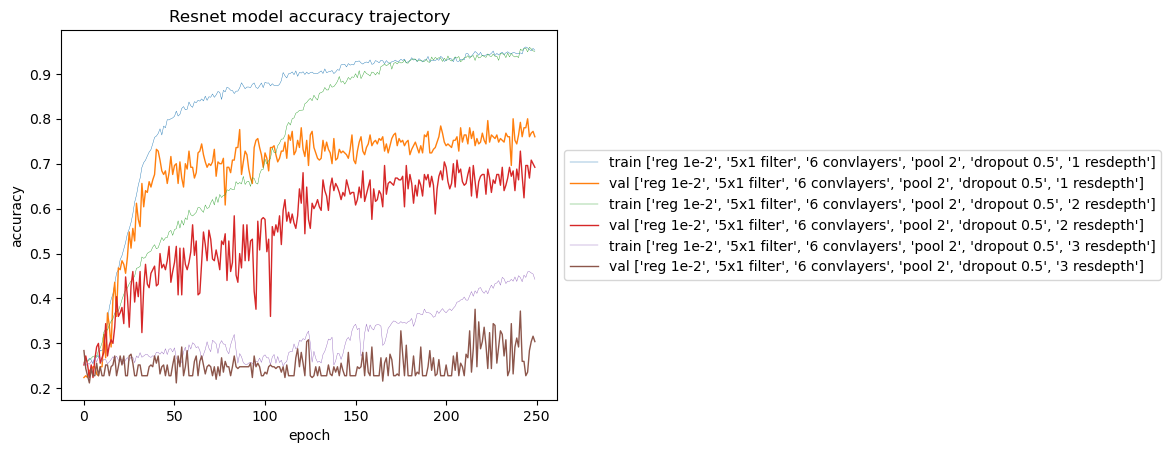

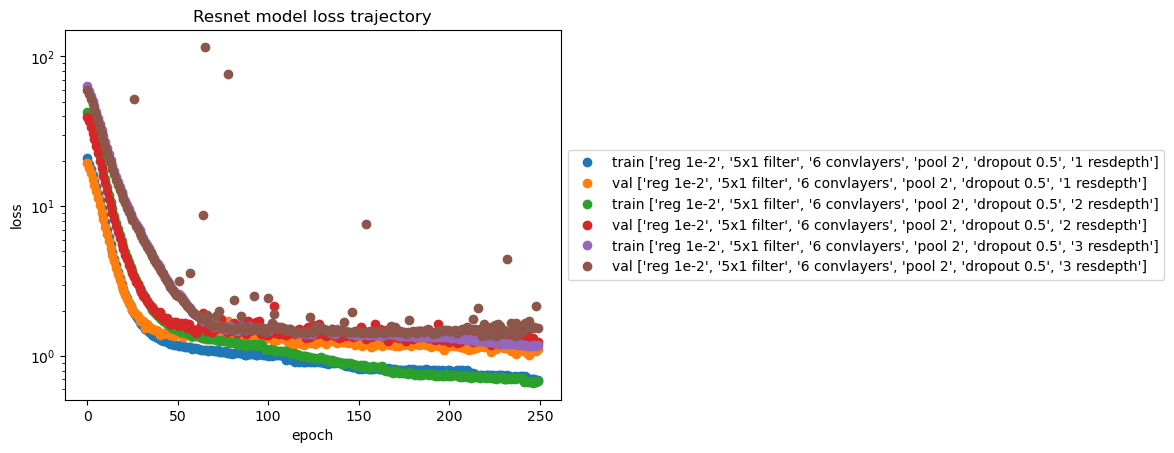

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
for hist in histories:
    plt.plot(hist.history['accuracy'], linewidth=0.3)
    plt.plot(hist.history['val_accuracy'], linewidth=1)
plt.title('Resnet model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = []
for name in models_names:
    labels.append(f'train {name}')
    labels.append(f'val {name}')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for hist in histories:
    plt.plot(hist.history['loss'],'o')
    plt.plot(hist.history['val_loss'],'o')
plt.title('Resnet model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
## Testing the basic CNN model
from keras.models import save_model
from keras.utils import plot_model

for model_, name in zip(models, models_names):
    cnn_score = model_.evaluate(x_test, y_test, verbose=0)
    if cnn_score[1] > 0.7:
       # Save entire model
        model_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
        model_.save(model_filename)

        # Save weights only
        weights_filename = f'../Models/Custom_Resnet_weights{cnn_score[1]}.h5'
        model_.save_weights(weights_filename) 
    print(f'Test accuracy of {name}:',cnn_score[1])


/home/big/miniforge3/envs/c147/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy of ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '1 resdepth']: 0.7178329825401306
Test accuracy of ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '2 resdepth']: 0.6794582605361938
Test accuracy of ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '3 resdepth']: 0.33634310960769653


In [11]:
from keras.models import save_model
from keras.utils import plot_model

# Save entire model
# model_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
# model.save(model_filename)

# # Save weights only
# weights_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
# model.save_weights(weights_filename)
# Load weights into a new model with the same architecture
# loaded_model = create_resnet_lstm_model() # create using resnet-15 architecture
# loaded_model.load_weights(weights_filename)

In [12]:
maxes_ = []
finals_ = []
for hist, name in zip(histories, models_names):
    maxes_.append(max(hist.history['val_accuracy']))
    finals_.append(hist.history['val_accuracy'][-1])
    print(f"Validation accuracy {name}: max: {max(hist.history['val_accuracy'])}, final: {hist.history['val_accuracy'][-1]}")
for pair in sorted(zip(finals_, models_names), key=lambda i: i[0], reverse=True):
    print(pair)

Validation accuracy ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '1 resdepth']: max: 0.800000011920929, final: 0.7599999904632568
Validation accuracy ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '2 resdepth']: max: 0.7279999852180481, final: 0.6919999718666077
Validation accuracy ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '3 resdepth']: max: 0.37599998712539673, final: 0.30399999022483826
(0.7599999904632568, ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '1 resdepth'])
(0.6919999718666077, ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '2 resdepth'])
(0.30399999022483826, ['reg 1e-2', '5x1 filter', '6 convlayers', 'pool 2', 'dropout 0.5', '3 resdepth'])


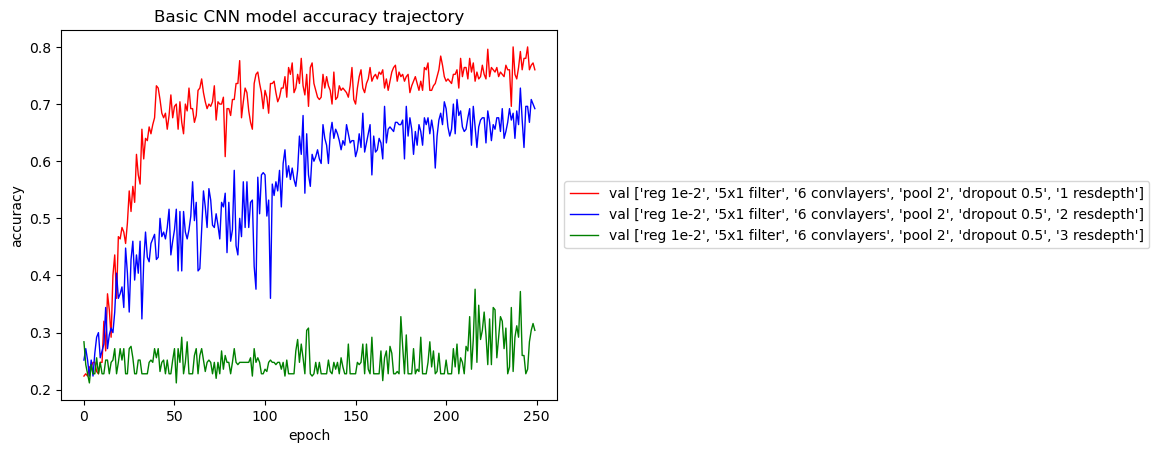

In [13]:
color = ['r', 'b', 'g', 'orange', 'yellow', 'violet']
for param in [h.items() for h in hyperparams]:
    if len(param) == 1:
        continue
    for i, param_name in enumerate(param):
        for name, label, history in zip(models_names, labels[1::2], histories):
            if param_name[0] in name:
                plt.plot(history.history['val_accuracy'], linewidth=1, color=color[i], label=label)
    plt.title('Basic CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()